<a href="https://colab.research.google.com/github/soheilraeiss/Statistical-Methods/blob/main/StatisticalMethods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Cell 1: Libraries and data setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Hassan's scores from 2015-2021 (prior data)
X = np.array([3,9,6,6,16,6,8,10,9,12,10,9,13,6,10,7,10,4,11,11,
              10,4,10,10,12,10,13,12,10,12,11,10,11,10,10,6,16,11,
              11,10,10,11,5,11,5,9,10,10,10,10,3,7,12,11,6,8,10,12])

# Hassan's 2022 scores
Y = np.array([11,12,12,1,10,11,10])

print("Data loaded successfully!")
print(f"Prior data (2015-2021): {len(X)} matches")
print(f"2022 data: {len(Y)} matches")


Data loaded successfully!
Prior data (2015-2021): 58 matches
2022 data: 7 matches


In [4]:
# Cell 2: Step 1 - Classical estimation and parameter estimation
mu_hat = X.mean()
sigma2_hat = X.var(ddof=1)
sigma_hat = np.sqrt(sigma2_hat)

print("Step 1: Classical Parameter Estimation")
print("="*40)
print(f"Sample mean (μ̂): {mu_hat:.2f}")
print(f"Sample variance (σ̂²): {sigma2_hat:.2f}")
print(f"Sample standard deviation (σ̂): {sigma_hat:.2f}")

# Generate 1000 random numbers from estimated normal distribution
gen_prior = np.random.normal(mu_hat, sigma_hat, 1000)

print(f"\nGenerated 1000 samples from N({mu_hat:.2f}, {sigma2_hat:.2f})")
print(f"Generated sample mean: {gen_prior.mean():.2f}")
print(f"Generated sample std: {gen_prior.std():.2f}")


Step 1: Classical Parameter Estimation
Sample mean (μ̂): 9.40
Sample variance (σ̂²): 7.86
Sample standard deviation (σ̂): 2.80

Generated 1000 samples from N(9.40, 7.86)
Generated sample mean: 9.45
Generated sample std: 2.74


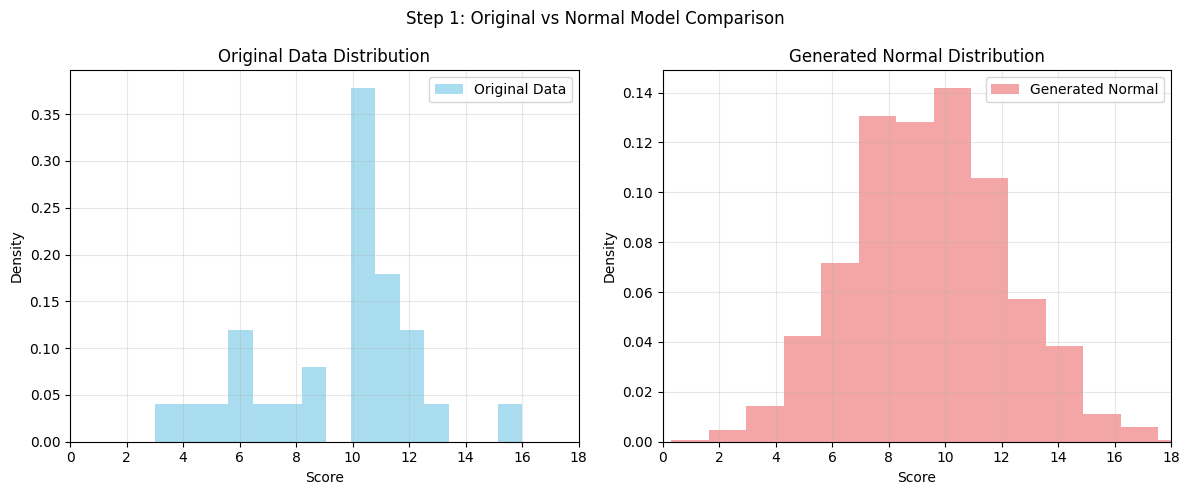

In [5]:
# Cell 3: Plot original data vs generated normal distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left subplot: Original data
ax1.hist(X, bins=15, density=True, alpha=0.7, color='skyblue', label='Original Data')
ax1.set_xlabel('Score')
ax1.set_ylabel('Density')
ax1.set_title('Original Data Distribution')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xlim(0, 18)

# Right subplot: Generated normal
ax2.hist(gen_prior, bins=15, density=True, alpha=0.7, color='lightcoral', label='Generated Normal')
ax2.set_xlabel('Score')
ax2.set_ylabel('Density')
ax2.set_title('Generated Normal Distribution')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim(0, 18)

plt.suptitle('Step 1: Original vs Normal Model Comparison')
plt.tight_layout()
plt.show()


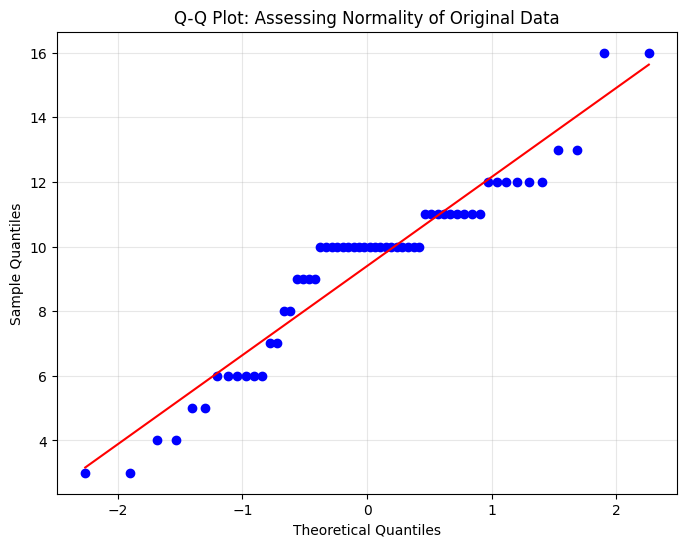

In [6]:
# Cell 4: Q-Q plot to assess normality
plt.figure(figsize=(8, 6))
stats.probplot(X, dist="norm", plot=plt)
plt.title('Q-Q Plot: Assessing Normality of Original Data')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True, alpha=0.3)
plt.show()


In [7]:
# Cell 5: Step 2 - Bayesian update calculations
print("Step 2: Bayesian Update with 2022 Data")
print("="*40)

# Given parameters
lam = 8.4  # known variance for 2022 data
y_bar = Y.mean()
n = len(Y)

print(f"2022 data mean (ȳ): {y_bar:.2f}")
print(f"Number of 2022 matches (n): {n}")
print(f"Known variance (λ): {lam}")

# Bayesian update using normal-normal conjugacy
# Posterior variance
sigma2_post = 1 / (n/lam + 1/sigma2_hat)

# Posterior mean
mu_post = sigma2_post * ((n/lam) * y_bar + mu_hat/sigma2_hat)

print(f"\nPosterior parameters:")
print(f"Posterior mean (μ_post): {mu_post:.2f}")
print(f"Posterior variance (σ²_post): {sigma2_post:.2f}")
print(f"Posterior std (σ_post): {np.sqrt(sigma2_post):.2f}")

# Generate samples from posterior distribution
theta_post = np.random.normal(mu_post, np.sqrt(sigma2_post), 1000)

print(f"\nGenerated 1000 samples from posterior N({mu_post:.2f}, {sigma2_post:.2f})")


Step 2: Bayesian Update with 2022 Data
2022 data mean (ȳ): 9.57
Number of 2022 matches (n): 7
Known variance (λ): 8.4

Posterior parameters:
Posterior mean (μ_post): 9.55
Posterior variance (σ²_post): 1.04
Posterior std (σ_post): 1.02

Generated 1000 samples from posterior N(9.55, 1.04)


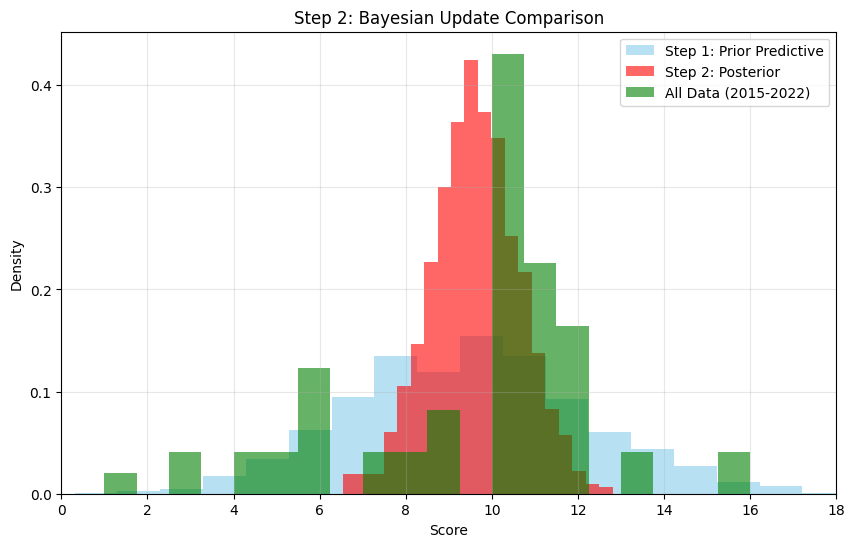

In [8]:
# Cell 6: Compare prior predictive, posterior, and all data
all_scores = np.hstack([X, Y])

plt.figure(figsize=(10, 6))
plt.hist(gen_prior, bins=20, density=True, alpha=0.6, color='skyblue', label='Step 1: Prior Predictive')
plt.hist(theta_post, bins=20, density=True, alpha=0.6, color='red', label='Step 2: Posterior')
plt.hist(all_scores, bins=20, density=True, alpha=0.6, color='green', label='All Data (2015-2022)')

plt.xlabel('Score')
plt.ylabel('Density')
plt.title('Step 2: Bayesian Update Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 18)
plt.show()


In [9]:
# Cell 7: Step 3 setup and Gibbs sampling implementation
print("Step 3: Latent-Fitness Mixture Model Setup")
print("="*45)

# Assumption: Hassan wins ~90% of matches (well-prepared)
p = 0.9
print(f"Probability of being well-prepared (p): {p}")

# Estimate mu1 (top 90% scores) and mu0 (bottom 10% scores)
sorted_X = np.sort(X)
n_top90 = int(0.9 * len(X))
n_bottom10 = len(X) - n_top90

mu1 = np.mean(sorted_X[n_bottom10:])  # top 90%
mu0 = np.mean(sorted_X[:n_bottom10])  # bottom 10%

print(f"\nPrior means estimation:")
print(f"μ₁ (well-prepared, top 90%): {mu1:.2f}")
print(f"μ₀ (not prepared, bottom 10%): {mu0:.2f}")

# Initialize parameters
theta1, theta0 = mu1, mu0

# Storage for samples
n_iterations = 1200
burn_in = 200
t1_samples, t0_samples = [], []

print(f"\nRunning Gibbs sampling: {n_iterations} iterations with {burn_in} burn-in...")

# Gibbs sampling loop
for iteration in range(n_iterations):
    # Step 1: Sample Z given current theta values
    pdf1 = p * norm.pdf(all_scores, theta1, np.sqrt(lam))
    pdf0 = (1-p) * norm.pdf(all_scores, theta0, np.sqrt(lam))
    prob_Z1 = pdf1 / (pdf1 + pdf0)

    # Generate Z samples
    Z = np.random.binomial(1, prob_Z1)

    # Step 2: Sample theta given Z
    for Z_val, mu_prior in [(1, mu1), (0, mu0)]:
        Y_subset = all_scores[Z == Z_val]
        n_subset = len(Y_subset)

        if n_subset > 0:
            # Normal-normal conjugacy
            posterior_var = 1 / (n_subset/lam + 1/sigma2_hat)
            posterior_mean = posterior_var * ((n_subset/lam) * Y_subset.mean() + mu_prior/sigma2_hat)

            if Z_val == 1:
                theta1 = np.random.normal(posterior_mean, np.sqrt(posterior_var))
            else:
                theta0 = np.random.normal(posterior_mean, np.sqrt(posterior_var))
        else:
            # Sample from prior if no observations
            if Z_val == 1:
                theta1 = np.random.normal(mu_prior, np.sqrt(sigma2_hat))
            else:
                theta0 = np.random.normal(mu_prior, np.sqrt(sigma2_hat))

    # Store samples
    t1_samples.append(theta1)
    t0_samples.append(theta0)

# Remove burn-in samples
theta1_posterior = np.array(t1_samples[burn_in:])
theta0_posterior = np.array(t0_samples[burn_in:])

print(f"\nPosterior Statistics (after {burn_in} burn-in):")
print(f"θ₁ (well-prepared): mean={theta1_posterior.mean():.2f}, std={theta1_posterior.std():.2f}")
print(f"θ₀ (not prepared): mean={theta0_posterior.mean():.2f}, std={theta0_posterior.std():.2f}")


Step 3: Latent-Fitness Mixture Model Setup
Probability of being well-prepared (p): 0.9

Prior means estimation:
μ₁ (well-prepared, top 90%): 10.02
μ₀ (not prepared, bottom 10%): 4.00

Running Gibbs sampling: 1200 iterations with 200 burn-in...

Posterior Statistics (after 200 burn-in):
θ₁ (well-prepared): mean=9.81, std=0.44
θ₀ (not prepared): mean=5.20, std=1.97


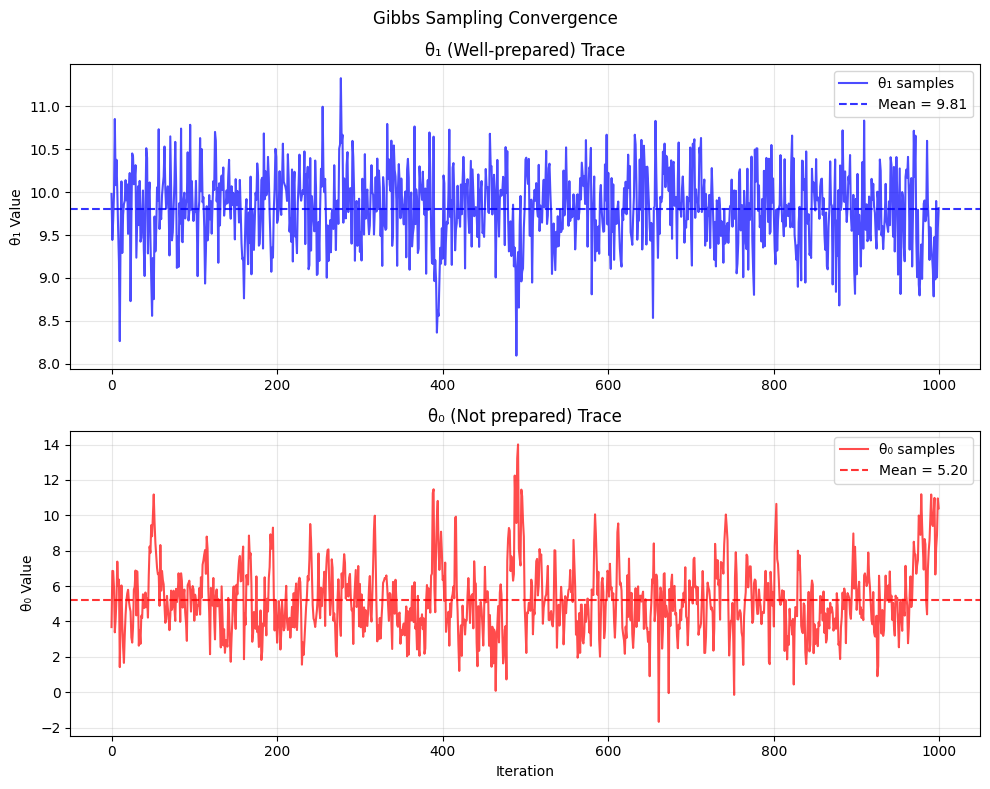

In [10]:
# Cell 8: Plot Gibbs sampling traces
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Theta1 trace
ax1.plot(theta1_posterior, color='blue', alpha=0.7, label='θ₁ samples')
ax1.axhline(y=theta1_posterior.mean(), color='blue', linestyle='--', alpha=0.8, label=f'Mean = {theta1_posterior.mean():.2f}')
ax1.set_ylabel('θ₁ Value')
ax1.set_title('θ₁ (Well-prepared) Trace')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Theta0 trace
ax2.plot(theta0_posterior, color='red', alpha=0.7, label='θ₀ samples')
ax2.axhline(y=theta0_posterior.mean(), color='red', linestyle='--', alpha=0.8, label=f'Mean = {theta0_posterior.mean():.2f}')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('θ₀ Value')
ax2.set_title('θ₀ (Not prepared) Trace')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.suptitle('Gibbs Sampling Convergence')
plt.tight_layout()
plt.show()


In [11]:
# Cell 9: Generate 2023 predictive samples
print("Generating 2023 Predictive Distribution")
print("="*38)

n_pred = 1000
pred_2023 = []

for i in range(n_pred):
    # Sample fitness state Z ~ Bernoulli(p)
    Z_pred = np.random.binomial(1, p)

    # Sample theta from posterior based on Z
    if Z_pred == 1:
        theta_pred = np.random.choice(theta1_posterior)
    else:
        theta_pred = np.random.choice(theta0_posterior)

    # Generate score Y ~ N(theta, lambda)
    score_pred = np.random.normal(theta_pred, np.sqrt(lam))
    pred_2023.append(score_pred)

pred_2023 = np.array(pred_2023)

print(f"Generated {n_pred} predictive samples for 2023")
print(f"Predictive mean: {pred_2023.mean():.2f}")
print(f"Predictive std: {pred_2023.std():.2f}")
print(f"95% predictive interval: [{np.percentile(pred_2023, 2.5):.1f}, {np.percentile(pred_2023, 97.5):.1f}]")

# Calculate probability of scoring above 7
prob_above_7 = np.mean(pred_2023 > 7)
print(f"Probability of scoring > 7: {prob_above_7:.3f}")


Generating 2023 Predictive Distribution
Generated 1000 predictive samples for 2023
Predictive mean: 9.32
Predictive std: 3.47
95% predictive interval: [1.8, 15.8]
Probability of scoring > 7: 0.767


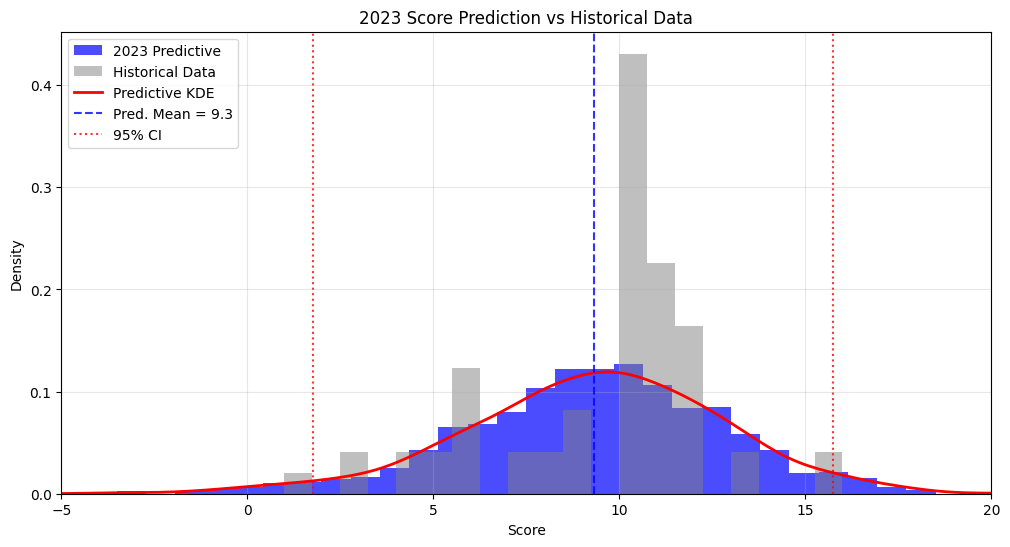

In [13]:
# Cell 10: Plot 2023 predictions vs historical data
plt.figure(figsize=(12, 6))

# Histograms
plt.hist(pred_2023, bins=30, density=True, alpha=0.7, color='blue', label='2023 Predictive')
plt.hist(all_scores, bins=20, density=True, alpha=0.5, color='gray', label='Historical Data')

# KDE for predictive distribution
from scipy.stats import gaussian_kde
kde = gaussian_kde(pred_2023)
x_range = np.linspace(-5, 20, 200)
plt.plot(x_range, kde(x_range), color='red', linewidth=2, label='Predictive KDE')

# Vertical lines
plt.axvline(pred_2023.mean(), color='blue', linestyle='--', alpha=0.8, label=f'Pred. Mean = {pred_2023.mean():.1f}')
plt.axvline(np.percentile(pred_2023, 2.5), color='red', linestyle=':', alpha=0.8, label='95% CI')
plt.axvline(np.percentile(pred_2023, 97.5), color='red', linestyle=':', alpha=0.8)

plt.xlabel('Score')
plt.ylabel('Density')
plt.title('2023 Score Prediction vs Historical Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-5, 20)
plt.show()


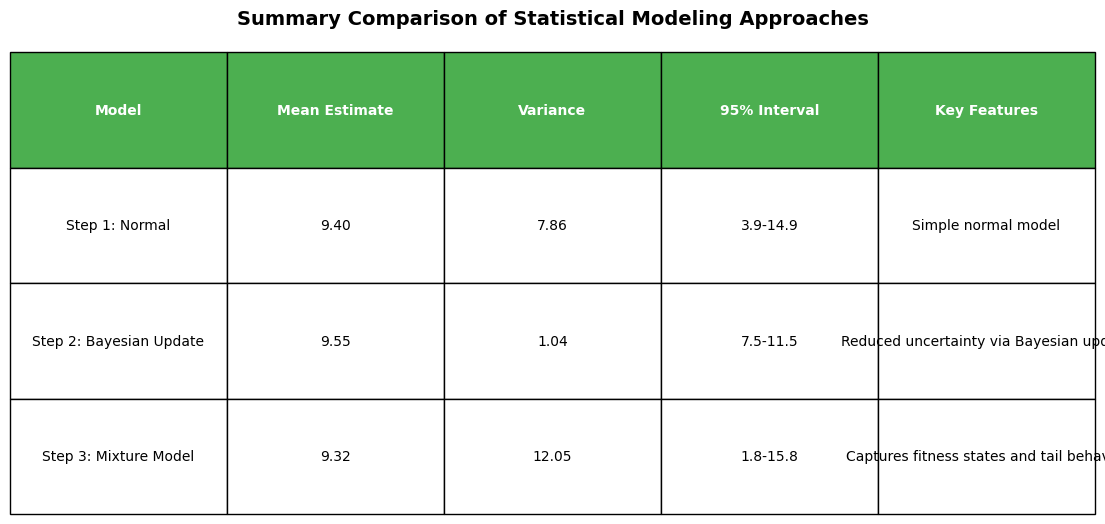

In [14]:
# Cell 11: Create summary table
import matplotlib.pyplot as plt

# Create summary data
models = ['Step 1: Normal', 'Step 2: Bayesian Update', 'Step 3: Mixture Model']
means = [mu_hat, mu_post, pred_2023.mean()]
variances = [sigma2_hat, sigma2_post, pred_2023.var()]
intervals = [f'{mu_hat-1.96*sigma_hat:.1f}-{mu_hat+1.96*sigma_hat:.1f}',
             f'{mu_post-1.96*np.sqrt(sigma2_post):.1f}-{mu_post+1.96*np.sqrt(sigma2_post):.1f}',
             f'{np.percentile(pred_2023, 2.5):.1f}-{np.percentile(pred_2023, 97.5):.1f}']
features = ['Simple normal model', 'Reduced uncertainty via Bayesian update', 'Captures fitness states and tail behavior']

# Create table
fig, ax = plt.subplots(figsize=(14, 6))
ax.axis('tight')
ax.axis('off')

table_data = []
table_data.append(['Model', 'Mean Estimate', 'Variance', '95% Interval', 'Key Features'])
for i in range(3):
    table_data.append([models[i], f'{means[i]:.2f}', f'{variances[i]:.2f}', intervals[i], features[i]])

table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style the header row
for i in range(5):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Summary Comparison of Statistical Modeling Approaches', pad=20, fontsize=14, weight='bold')
plt.show()
